# Imports

In [1]:
import pandas as pd
import numpy as np

# Read data

In [2]:
# Read data
df = pd.read_csv('/kaggle/input/ibm-classification-feature-engineering/all_data.csv')
df.drop(['Unnamed: 0', 'Unnamed: 0.1'], inplace=True, axis=1)

In [3]:
df.head(5)

,Symbol,Volume,Home Price Index,Sector_Basic Materials,Sector_Communication Services,Sector_Consumer Cyclical,Sector_Consumer Defensive,Sector_Energy,Sector_Financial Services,Sector_Healthcare,...,Adj Close 26-Day EMA Differenced,Adj Close 7-Day Upper Bollinger Band Differenced,Adj Close 7-Day Lower Bollinger Band Differenced,True Range 26-Day SMA Differenced,Adj Close Differenced,Close Differenced,High Differenced,Low Differenced,Open Differenced,S&P500 Differenced
0,40,730000.0,145.632,0,0,0,0,0,0,0,...,0.039025,0.045485,0.060711,0.010635,-0.007149,-0.010000,0.070000,0.090000,0.230000,9.86
1,90,495800.0,145.632,0,0,0,0,0,0,1,...,-0.016047,0.093910,0.085535,-0.013197,-0.251247,-0.260002,0.129997,0.129997,0.330002,9.86
2,456,1149800.0,145.632,0,0,0,0,0,0,0,...,0.037636,0.397650,-0.114312,0.010786,0.399628,0.540001,0.309998,0.480003,0.449997,9.86
3,188,8802400.0,145.632,0,0,0,0,0,0,1,...,0.079440,0.238781,0.185112,0.009048,0.430737,0.540001,0.290001,0.059998,0.270000,9.86
4,404,708900.0,145.632,0,0,0,0,0,1,0,...,0.544610,2.380876,0.865951,-0.136414,1.504242,1.819977,1.990021,2.419983,2.440002,9.86


# Feature Selection

Throughout this notebook, we use this article on feature selection to help out https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection

In [4]:
# Training set
X_train = df[(df['Year'] >= 2014) & (df['Year'] <= 2019)]
y_train = X_train['1-week Forward Return Sign']
X_train.drop(['1-week Forward Return Sign'], inplace=True, axis=1)

# Test set (with gap)
X_test = df[df['Year'] >= 2021]
y_test = X_test['1-week Forward Return Sign']
X_test.drop(['1-week Forward Return Sign'], inplace=True, axis=1)

# Print shapes
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (632327, 214)
y_train: (632327,)
X_test: (153972, 214)
y_test: (153972,)


/tmp/ipykernel_17/3444017898.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['1-week Forward Return Sign'], inplace=True, axis=1)
/tmp/ipykernel_17/3444017898.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(['1-week Forward Return Sign'], inplace=True, axis=1)


In [5]:
# Scale features using training set mean and std to avoid look-ahead bias
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_normalized = pd.DataFrame(
    data=scaler.fit_transform(X_train),
    columns=X_train.columns
)
X_test_normalized = pd.DataFrame(
    data=scaler.transform(X_test),
    columns=X_test.columns
)

## Filter Methods

Filter methods are generally used as a preprocessing step. The selection of features is independent of any machine learning algorithms. Instead, features are selected on the basis of their scores in various statistical tests for their correlation with the outcome variable. For classification problems like this one, correlation-based filter methods tend to yield the best results and are less computationally expensive than training a model and doing some sort of recursive feature selection.

### Remove low variance features

In [6]:
# Check if any features have 0 variance
from sklearn.feature_selection import VarianceThreshold
zero_threshold = VarianceThreshold(threshold=0)
zero_threshold.fit(X_train)
num_constant_features = len(X_train.columns) - sum(zero_threshold.get_support())
print(f"There are {num_constant_features} constant features")

There are 0 constant features


In [7]:
# Find 'almost' constant features
almost_constant_threshold = VarianceThreshold(threshold=0.01)
almost_constant_threshold.fit(X_train_normalized)
num_almost_constant_features = len(X_train_normalized.columns) - sum(almost_constant_threshold.get_support())
print(f"There are {num_almost_constant_features} almost constant features")
print([c for c in X_train_normalized.columns if c not in X_train_normalized.columns[almost_constant_threshold.get_support()]])

# Remove 'almost constant' features
X_train_normalized = pd.DataFrame(almost_constant_threshold.transform(X_train_normalized), columns=X_train_normalized.columns[almost_constant_threshold.get_support()])
X_test_normalized = pd.DataFrame(almost_constant_threshold.transform(X_test_normalized), columns=X_test_normalized.columns[almost_constant_threshold.get_support()])

# Check shapes to ensure features have been removed
print(f"X_train_normalized: {X_train_normalized.shape}")
print(f"X_test_normalized: {X_test_normalized.shape}")

There are 0 almost constant features
[]
X_train_normalized: (632327, 214)
X_test_normalized: (153972, 214)


### Remove highly correlated features using correlation matrix

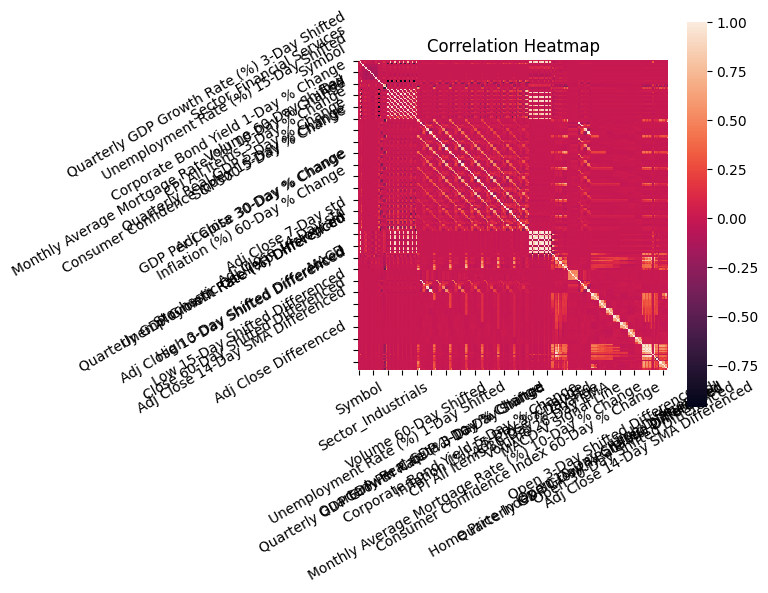

In [8]:
# Create correlation matrix of remaining features
corr_matrix = X_train_normalized.corr()

# Create correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
plt.title('Correlation Heatmap')
a = sns.heatmap(corr_matrix, square=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

In [9]:
# Get columns of correlation matrix that have high correlation to other features (need upper triangular matrix to stop wrong features being dropped)
correlation_threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in list(upper.columns) if any(upper[column] > correlation_threshold)]
print(to_drop)  

['Unemployment Rate (%) 3-Day Shifted', 'Quarterly GDP Growth Rate (%) 3-Day Shifted', 'Unemployment Rate (%) 5-Day Shifted', 'Quarterly GDP Growth Rate (%) 5-Day Shifted', 'Unemployment Rate (%) 10-Day Shifted', 'Quarterly GDP Growth Rate (%) 10-Day Shifted', 'Unemployment Rate (%) 15-Day Shifted', 'Quarterly GDP Growth Rate (%) 15-Day Shifted', 'Unemployment Rate (%) 30-Day Shifted', 'Unemployment Rate (%) 60-Day Shifted', 'Quarterly Real GDP 1-Day % Change', 'Quarterly Real GDP 3-Day % Change', 'Quarterly Real GDP 5-Day % Change', 'Quarterly Real GDP 10-Day % Change', 'Quarterly Real GDP 15-Day % Change', 'Quarterly Real GDP 30-Day % Change', 'Volume 7-Day SMA', 'Volume 7-Day EMA', 'Volume 12-Day SMA', 'Volume 12-Day EMA', 'Adj Close 12-Day std', 'Volume 12-Day std', 'Volume 14-Day SMA', 'Volume 14-Day EMA', 'Adj Close 14-Day std', 'Volume 14-Day std', 'Volume 26-Day EMA', 'Adj Close 26-Day std', 'Volume 26-Day std', 'MACD Signal Line', 'MACD-V Signal Line', 'Stochastic Oscillator %

In [10]:
# Drop highly correlated features from X_train and X_test
X_train_normalized.drop(to_drop, axis=1, inplace=True)
X_test_normalized.drop(to_drop, axis=1, inplace=True)

# Check shapes to ensure features have been removed
print(f"X_train_normalized: {X_train_normalized.shape}")
print(f"X_test_normalized: {X_test_normalized.shape}")

X_train_normalized: (632327, 161)
X_test_normalized: (153972, 161)


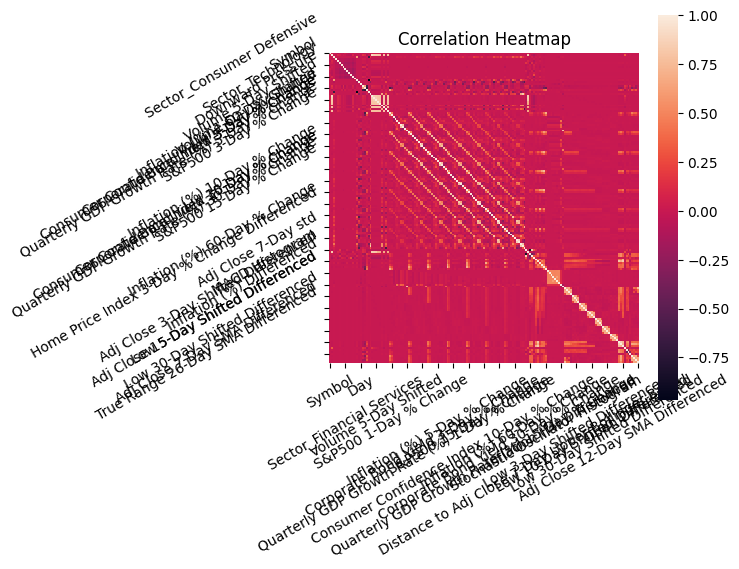

In [11]:
# Create correlation matrix of remaining features
corr_matrix = X_train_normalized.corr()

# Create correlation heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
plt.title('Correlation Heatmap')
a = sns.heatmap(corr_matrix, square=True, fmt='.2f', linecolor='black')
a.set_xticklabels(a.get_xticklabels(), rotation=30)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

## Wrapper Methods

Wrapper methods eliminate features by looking at weights/coefficients of features in a trained model. In this case we use CatBoost's built-in method select_features(). This selects a subset of features based on their SHAP (SHapely Additive exPlanations) values, which measure their contribution to the final outcome.

In [12]:
# Get training and eval set to use while selecting features
from sklearn.model_selection import train_test_split
X_train_cb, X_val_cb, y_train_cb, y_val_cb = train_test_split(
    X_train_normalized, 
    y_train, 
    test_size=0.20, 
    shuffle=False
)

# Print shapes
print(f"X_train_cb: {X_train_cb.shape}")
print(f"y_train_cb: {y_train_cb.shape}")
print(f"X_val_cb: {X_val_cb.shape}")
print(f"y_val_cb: {y_val_cb.shape}")

X_train_cb: (505861, 161)
y_train_cb: (505861,)
X_val_cb: (126466, 161)
y_val_cb: (126466,)


In [13]:
# Get training and validation pools
from catboost import Pool
feature_names = list(X_train_cb.columns)
train_pool = Pool(X_train_cb, y_train_cb, feature_names=feature_names)
val_pool = Pool(X_val_cb, y_val_cb, feature_names=feature_names)

# Build CatBoost model
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=25000,
    learning_rate=0.01,
    early_stopping_rounds=250,
    loss_function='Logloss'
)

In [14]:
# Select best features
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
summary = model.select_features(
    X=train_pool,
    eval_set=val_pool,
    features_for_select=f'0-{len(feature_names) - 1}',
    num_features_to_select=int(0.65*len(feature_names)),
    steps=10,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=False,
    logging_level="Verbose",
    plot=True
)
print(summary)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Step #1 out of 10
0:	learn: 0.6923506	test: 0.6928471	best: 0.6928471 (0)	total: 354ms	remaining: 2h 27m 26s
1:	learn: 0.6918134	test: 0.6925258	best: 0.6925258 (1)	total: 611ms	remaining: 2h 7m 18s
2:	learn: 0.6912448	test: 0.6921087	best: 0.6921087 (2)	total: 874ms	remaining: 2h 1m 24s
3:	learn: 0.6906077	test: 0.6919349	best: 0.6919349 (3)	total: 1.21s	remaining: 2h 6m 11s
4:	learn: 0.6899358	test: 0.6916102	best: 0.6916102 (4)	total: 1.64s	remaining: 2h 16m 55s
5:	learn: 0.6893550	test: 0.6915224	best: 0.6915224 (5)	total: 2.01s	remaining: 2h 19m 30s
6:	learn: 0.6887418	test: 0.6911872	best: 0.6911872 (6)	total: 2.4s	remaining: 2h 22m 32s
7:	learn: 0.6881186	test: 0.6909059	best: 0.6909059 (7)	total: 2.73s	remaining: 2h 22m 10s
8:	learn: 0.6875104	test: 0.6905624	best: 0.6905624 (8)	total: 3s	remaining: 2h 19m 4s
9:	learn: 0.6869774	test: 0.6903046	best: 0.6903046 (9)	total: 3.26s	remaining: 2h 15m 47s
10:	learn: 0.6863776	test: 0.6900840	best: 0.6900840 (10)	total: 3.48s	remaining

{'selected_features': [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 35, 36, 37, 38, 39, 40, 46, 48, 49, 50, 56, 59, 60, 64, 65, 68, 70, 75, 77, 79, 80, 81, 82, 84, 85, 86, 88, 90, 91, 95, 98, 99, 100, 101, 102, 103, 104, 106, 107, 109, 112, 113, 119, 120, 121, 122, 123, 124, 125, 126, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 153, 156, 158, 160], 'eliminated_features_names': ['S&P500 10-Day % Change', 'S&P500 15-Day % Change', 'Quarterly GDP Growth Rate (%) 30-Day Shifted', 'S&P500 5-Day % Change', 'Unemployment Rate (%) 60-Day % Change', 'Inflation (%) 60-Day % Change', 'Corporate Bond Yield 15-Day % Change', 'S&P500 60-Day % Change', 'S&P500 3-Day % Change', 'Unemployment Rate (%) 5-Day % Change', 'Monthly Average Mortgage Rate (%) 5-Day % Change', 'Consumer Confidence Index 15-Day % Change', 'MACD Histogram', 'S&P500 1-Day % Change', 'Adj Close 7-Day SMA Differ

In [15]:
# Drop unwanted features from dataframes
X_train_normalized = X_train_normalized[summary['selected_features_names']]
X_test_normalized = X_test_normalized[summary['selected_features_names']]

## Write outputs

In [16]:
# # Training set, test set and selected features
# X_train_normalized.to_csv(path_or_buf="X_train_normalized.csv")
# X_test_normalized.to_csv(path_or_buf="X_test_normalized.csv")
# y_train.to_csv(path_or_buf="y_train.csv")
# y_test.to_csv(path_or_buf="y_test.csv")